In [3]:
import numpy
import scipy
import netCDF4
import matplotlib.pyplot as mp
import matplotlib.ticker
import matplotlib.colors
import scipy.stats
import pandas
import itertools

import mpl_toolkits
from mpl_toolkits import basemap

mp.rcParams.update({'mathtext.default': 'regular'})
% matplotlib inline

In [4]:
working_dir = '/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/'
#save_dir = '/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/calculations/npy_files/'
#latlon_indices = numpy.load(working_dir + 'ccal_latlon_indices_array.npy'); region='ccal'
#latlon_indices = numpy.load(working_dir + 'ncal_latlon_indices_array.npy'); region='ncal'
#latlon_indices = numpy.load(working_dir + 'scal_latlon_indices_array.npy'); region='scal'

PRECT_lat = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/PRECT_lat.npy')
PRECT_lon = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/PRECT_lon.npy')

In [5]:
working_dir = '/Users/baird/google_drive/_data_original/NCAR_LENS/daily/PRECT/calculated_npy_files/'
#threshold=0.0
threshold=0.1
#threshold=0.5
#threshold=1.0
#threshold=5.0
#threshold=10.0

In [6]:
# make color map
minval=0.0 # 
maxval=0.95 #
n=256
full_cmap = mp.get_cmap('RdBu')
cmap_partial = matplotlib.colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=full_cmap.name, a=minval, b=maxval), full_cmap(numpy.linspace(minval, maxval, n)))

In [7]:
PRECT_nlat = 26
PRECT_nlon = 25

latlon_indices = list(itertools.product(range(PRECT_nlat), range(PRECT_nlon)))
region = 'whole_domain'
window=1

In [8]:
extreme_values_40d = pandas.read_csv('csv_files/extreme_values_40d_sums_dataframe_pic.csv')
extreme_values_40d_data = extreme_values_40d.values[:,1:]
# each row is a latlon value
# each column is a different season
# for each row, find the 95th percentile across all seasons
# plot them as histograms first

In [9]:
#bins = numpy.linspace(sum_40d_array.min(), sum_40d_array.max(), 500)
latlon_idx = 647

bins = numpy.linspace(extreme_values_40d_data[latlon_idx,:].min(), extreme_values_40d_data[latlon_idx,:].max(), 50)
#hist_count, bin_edges = numpy.histogram(extreme_values_40d[latlon_idx,:], bins=bins, density=False)
hist, bin_edges = numpy.histogram(extreme_values_40d_data[latlon_idx,:], bins=bins, density=True)
bin_centers = (bin_edges[:-1]+bin_edges[1:])/2
bin_width = numpy.diff(bin_edges)

In [10]:
perc=99.5
scores_at_perc = numpy.zeros((PRECT_nlat*PRECT_nlon))
for latlon_idx in range(len(latlon_indices)):
    scores_at_perc[latlon_idx] = scipy.stats.scoreatpercentile(extreme_values_40d_data[latlon_idx,:], perc)
scores_at_perc_2d = scores_at_perc.reshape((PRECT_nlat, PRECT_nlon))

In [11]:
#year_start = 1920
#year_end = 2100

year_start_list = [1920,1950,1980,2010,2040,2070]
year_end_list = [1950,1980,2010,2040,2070,2100]

year_start = year_start_list[5]
year_end = year_end_list[5]

# create season strings
years = numpy.arange(year_start, year_end+1, 1).astype(numpy.int)
half_years_hist_rcp = numpy.arange(year_start+0.75, year_end, 1)

season_strings_hist_rcp = [str(years[i])+'-'+str(years[i+1]) for i in range(years.size-1)]
member_strings_hist_rcp = ['{:03d}'.format(i) for i in range(1,36)]

n_seasons_hist_rcp=year_end-year_start

In [12]:
ensemble_members = numpy.hstack((numpy.arange(1,36), numpy.arange(101,106)))
ensemble_names = ['{:03d}'.format(i) for i in ensemble_members]

# Pull out only the year_start to year_end interval

In [13]:
extreme_values_40d_hist_rcp_list = []
for ensemble_idx in range(len(ensemble_names)):
    extreme_values_40d = pandas.read_csv('csv_files/extreme_values_40d_sums_dataframe_model_'+ensemble_names[ensemble_idx]+'_1920-2100.csv')
    extreme_values_40d_hist_rcp_list.append(extreme_values_40d[season_strings_hist_rcp].values)
print(extreme_values_40d_hist_rcp_list[0].shape)

(650, 30)


In [14]:
# collapse all lists into one full list
extreme_values_40d_hist_rcp_single_array = numpy.empty((extreme_values_40d_hist_rcp_list[0].shape[0],0))
#print(extreme_values_40d_hist_rcp_single_array.shape)
for ensemble_idx in range(len(ensemble_names)):
    #print(extreme_values_40d_hist_rcp_list[0].shape)
    extreme_values_40d_hist_rcp_single_array = numpy.hstack(( extreme_values_40d_hist_rcp_single_array, extreme_values_40d_hist_rcp_list[ensemble_idx] ))

In [15]:
perc=99.5
scores_at_perc_hist_rcp = numpy.zeros((PRECT_nlat*PRECT_nlon))
for latlon_idx in range(len(latlon_indices)):
    scores_at_perc_hist_rcp[latlon_idx] = scipy.stats.scoreatpercentile(extreme_values_40d_hist_rcp_single_array[latlon_idx,:], perc)
scores_at_perc_hist_rcp_2d = scores_at_perc_hist_rcp.reshape((PRECT_nlat, PRECT_nlon))

# Now calculate change in likelihood of a 200yr event

In [16]:
perc=99.5
perc_of_pic_score = numpy.zeros((PRECT_nlat*PRECT_nlon))
for latlon_idx in range(len(latlon_indices)):
    perc_of_pic_score[latlon_idx] = scipy.stats.percentileofscore(extreme_values_40d_hist_rcp_single_array[latlon_idx,:], scores_at_perc[latlon_idx])

change_likelihood = numpy.zeros((PRECT_nlat*PRECT_nlon))
for latlon_idx in range(len(latlon_indices)):
    change_likelihood[latlon_idx] = (100-perc_of_pic_score[latlon_idx])/(100-perc)
change_likelihood_2d = change_likelihood.reshape((PRECT_nlat,PRECT_nlon))

In [17]:
# make color map
minval=0.0 # 
maxval=0.9 #
n=256
full_cmap = mp.get_cmap('RdBu')
cmap_partial = matplotlib.colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=full_cmap.name, a=minval, b=maxval), full_cmap(numpy.linspace(minval, maxval, n)))

# Extreme value distro fitting

In [20]:
perc=99.5
perc_of_pic_score = numpy.zeros((PRECT_nlat*PRECT_nlon))
for latlon_idx in range(len(latlon_indices)):
    perc_of_pic_score[latlon_idx] = scipy.stats.percentileofscore(extreme_values_40d_hist_rcp_single_array[latlon_idx,:], scores_at_perc[latlon_idx])

#change_likelihood = numpy.zeros((PRECT_nlat*PRECT_nlon))
#for latlon_idx in range(len(latlon_indices)):
#    change_likelihood[latlon_idx] = (100-perc_of_pic_score[latlon_idx])/(100-perc)
#change_likelihood_2d = change_likelihood.reshape((PRECT_nlat,PRECT_nlon))

a = extreme_values_40d_hist_rcp_single_array[20,:]
a.shape

(1200,)

In [21]:
#distro_fit = scipy.stats.gamma.fit(a)
#distro_fit = scipy.stats.gumbel_r.fit(a)
distro_fit = scipy.stats.pearson3.fit(a)

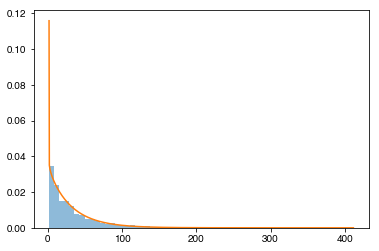

In [22]:
h = mp.hist(a, normed=True, bins=60, alpha=0.5)
x = numpy.linspace(a.min(), a.max(), 1000)
pdf_fitted = scipy.stats.pearson3.pdf(x, *distro_fit)
mp.plot(x, pdf_fitted, label='fit')

In [1]:
cdf_fitted = scipy.stats.pearson3.cdf(x, *distro_fit)
mp.plot(x, cdf_fitted, label='fit')

NameError: name 'scipy' is not defined

In [24]:
scipy.stats.pearson3.ppf(0.995, *distro_fit)

170.11204398092249

In [26]:
scipy.stats.pearson3.cdf(170, *distro_fit)

0.99498255999240903